In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import scanpy as sc
from matplotlib import pyplot as plt
import multigrate as mtg
import gdown

# Load the dataset

In [2]:
# download data if needed from https://drive.google.com/drive/folders/1vdO8CJluRp7sOOQHc85YYZXhV2p2QcDN
gdown.download(
    'https://drive.google.com/uc?id=1QK5Ua4HStjIm3URxw4WHHM2gdzDmbvsN',
    '../data/10xpbmc10k-2020/expressions.h5ad'
)

Downloading...
From: https://drive.google.com/uc?id=1QK5Ua4HStjIm3URxw4WHHM2gdzDmbvsN
To: /mnt/home/icb/anastasia.litinetskaya/multigrate/data/10xpbmc10k-2020/expressions.h5ad
48.8MB [00:00, 110MB/s] 


'../data/10xpbmc10k-2020/expressions.h5ad'

In [3]:
 gdown.download(
    'https://drive.google.com/uc?id=1OkryKwFCna0hWD_oUiRFknzVy72oaFfc',
    '../data/10xpbmc10k-2020/peaks.h5ad'
)

Downloading...
From: https://drive.google.com/uc?id=1OkryKwFCna0hWD_oUiRFknzVy72oaFfc
To: /mnt/home/icb/anastasia.litinetskaya/multigrate/data/10xpbmc10k-2020/peaks.h5ad
789MB [00:05, 153MB/s]  


'../data/10xpbmc10k-2020/peaks.h5ad'

In [4]:
scrna = sc.read_h5ad('../data/10xpbmc10k-2020/expressions.h5ad')
scrna

AnnData object with n_obs × n_vars = 10000 × 3999
    obs: 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'count'
    obsp: 'connectivities', 'distances'

In [5]:
scatac = sc.read_h5ad('../data/10xpbmc10k-2020/peaks.h5ad')
scatac

AnnData object with n_obs × n_vars = 10000 × 40086
    obs: 'cell_type', 'nb_features'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'cell_type_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'binary'
    obsp: 'connectivities', 'distances'

# Configure and train the model

To configure the model, we need to specify the following parameters:
   - pair_groups = whether the dtaa is paired or not; if the data is paired same number should be passed, e.g. [[0], [0]] or [[1], [1]], if not paired then different numbers, e.g. [[0], [1]]
   - condition = whether the model is a cVAE. Set to True if using query to reference mapping
   - z_dim = number of dimentions in the latent space
   - h_dim = number of dimentions in the hidden space, i.e. output dimention of the modality encoders and input dimention of the shared encoder
   - hiddens = dimentionality of hidden layers in modality encoders/decoders; e.g. if hiddens = [[512], [1024]] then the input dimentions of modality encoders would be 3999 -> 512 -> 128 for rna and 40018 -> 1024 -> 128 for atac
   - losses = loss per modality. Has to be one of ['mse', 'nb', 'zinb', 'bce']. We recomend using 'nb' with raw gene counts or 'mse' with normalized gene expressions, 'mse' with normalized protein data and 'bce' with binarized peaks or 'mse' with mormalized peaks
   - layers = which layer in AnnData onject to use. Default is to use .X but if layer is specified per modality, use that one.
   - output_actiations = activation funtions of the last layer of modelity decoders; has to be one of ['linear', 'relu', 'leakyrelu', 'sigmoid']
   - shared_hiddens = dimentionality of hidden layers in the shared encoder/decoder; e.g. if shared_hiddens = [64], then the input dimentions of the shared encoder would be 128 -> 64 -> 20
   - recon_coef = reconstruction coefficient, i.e. the weight of MSE reconstruction loss in the total loss (the higher the more important)
   - kl_coef = KL-divergence loss coefficient
   - cycle_coef = cycle consistency loss coefficient
   
Additionally, adatas, names, pair_groups and hiddens should have the same number of modalities and the same length per modality.

In [6]:
model = mtg.models.MultiVAE(
    adatas=[[scrna], [scatac]],
    names=[['scRNA-seq'], ['scATAC-seq']],
    pair_groups=[[0], [0]],
    condition=False,
    z_dim=20,
    h_dim=128,
    hiddens=[[], []],
    output_activations=['linear', 'linear'],
    losses=['nb', 'mse'],
    layers=[['count'], [None]],
    shared_hiddens=[],
    adver_hiddens=[],
    recon_coef=1,
    kl_coef=1e-4,
    integ_coef=1e-2,
    cycle_coef=0,
    adversarial=False,
    dropout=0.2,
)

In [7]:
model.train(
    n_iters=10000,
    batch_size=64,
    lr=3e-4,
    val_split=0.1,
    adv_iters=0,
    kl_anneal_iters=3500,
    validate_every=1000
)

 |████████████████████| 100.0% iter=10000/10000, time=24.28(s), loss=1.2714, recon=1.2692, kl=22.0782, integ=0.0000, cycle=0.0000, val_loss=1.2836, val_recon=1.2816, val_kl=19.6170, val_integ=0.0000, val_cycle=0.0000

## Plot training history

In [8]:
model.history

,iteration,train_loss,train_recon,train_kl,train_integ,train_cycle,val_loss,val_recon,val_kl,val_integ,val_cycle
0,1000,1.459775,1.459419,18.438933,0.0,0.0,1.298566,1.297943,21.823050,0,0
1,2000,1.289071,1.287788,27.877457,0.0,0.0,1.292501,1.290971,26.766577,0,0
2,3000,1.335222,1.333202,27.321331,0.0,0.0,1.290743,1.288744,23.313835,0,0
3,4000,1.296160,1.293775,24.458097,0.0,0.0,1.289025,1.286947,20.774010,0,0
4,5000,1.261911,1.259519,23.916486,0.0,0.0,1.287211,1.285166,20.448835,0,0
5,6000,1.301344,1.299022,23.217279,0.0,0.0,1.285806,1.283718,20.879951,0,0
6,7000,1.227870,1.225654,22.158169,0.0,0.0,1.285069,1.282957,21.112705,0,0
7,8000,1.344867,1.342559,23.080264,0.0,0.0,1.284378,1.282320,20.579636,0,0
8,9000,1.281015,1.278813,22.020388,0.0,0.0,1.283930,1.281907,20.224535,0,0
9,9999,1.271373,1.269166,22.078166,0.0,0.0,1.283585,1.281623,19.617029,0,0


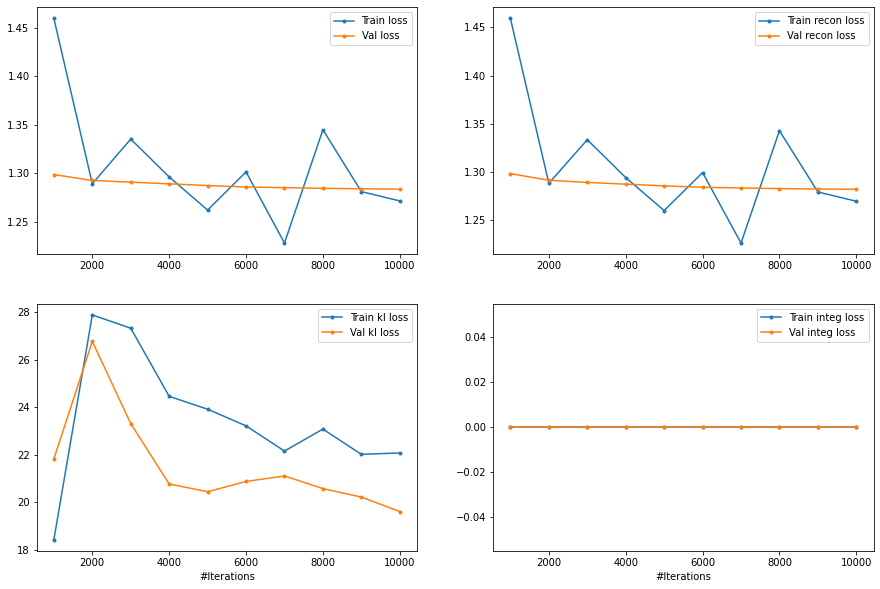

In [9]:
plt.figure(figsize=(15, 10));
plt.subplot(221);
plt.plot(model.history['iteration'], model.history['train_loss'], '.-', label='Train loss');
plt.plot(model.history['iteration'], model.history['val_loss'], '.-', label='Val loss');
plt.legend();

plt.subplot(222);
plt.plot(model.history['iteration'], model.history['train_recon'], '.-', label='Train recon loss');
plt.plot(model.history['iteration'], model.history['val_recon'], '.-', label='Val recon loss');
plt.legend();

plt.subplot(223);
plt.plot(model.history['iteration'], model.history['train_kl'], '.-', label='Train kl loss');
plt.plot(model.history['iteration'], model.history['val_kl'], '.-', label='Val kl loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(224);
plt.plot(model.history['iteration'], model.history['train_integ'], '.-', label='Train integ loss');
plt.plot(model.history['iteration'], model.history['val_integ'], '.-', label='Val integ loss');
plt.xlabel('#Iterations');
plt.legend();

# Validation

### UMAP plot of the latent space

In [10]:
z = model.predict(
    adatas=[[scrna], [scatac]],
    names=[['scRNA-seq'], ['scATAC-seq']],
    pair_groups=[[0], [0]],
    batch_size=64,
)
z

AnnData object with n_obs × n_vars = 10000 × 20
    obs: 'modality', 'barcode', 'cell_type', 'batch'

In [11]:
sc.pp.neighbors(z)
sc.tl.umap(z)

... storing 'modality' as categorical
... storing 'cell_type' as categorical


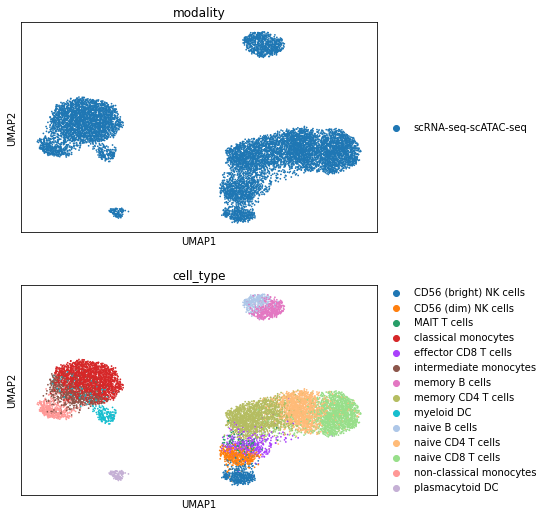

In [12]:
sc.pl.umap(z, color=['modality', 'cell_type'], ncols=1)